# Import libs

In [10]:
import time
from typing import List, Dict

import scipy.integrate
import autograd.numpy as np

import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

#import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# ODE

This step was to solve the ODE. Here, an implemetation of the ABM method for integration was used to solve the differential equation in the form of $ \frac{d\vec{z}(t)}{dt} = f(\vec{z}(t), t, \theta)$.

## State vector derivative

Here we define the derivative of the state vector:

In [60]:
def X_ddot(t, X):
    '''
    Returns the derivative of the state vector X
    ----------
    Arguments:
        t {float} -- time, in seconds
        X {np.array} -- state vector=(x, y, z, vx, vy, vz)
    ----------
    Returns:
        (6,1) np.array -- (xdot, ydot, zdot, vxdot, vydot, vzdot)
    '''
    
    x_dot = X[3:]
    v_dot = -mu*X[:3]/np.linalg.norm(X.detach().numpy())**3 # simply the acceleration
    X_dot_dot = np.concatenate((x_dot.detach().numpy(), v_dot.detach().numpy()), axis=None)

    X_dot_dot = torch.tensor(X_dot_dot, dtype=torch.float32, requires_grad=True)
    
    return X_dot_dot

## ODE Solver

In [18]:
def RK4(f, x0, tf, dt, t0=0):
    # Time vector
    t = np.arange(t0, tf, dt)
    nt = t.size
    
    # Constructing final vector
    nx = x0.size
    x = np.zeros((nx, nt))
    
    # Initial conditions
    x[:,0] = x0
    
    for k in range(nt-1):
        # At the kth time step, each parameter k_n is computed
        k1 = dt*f(t[k], x[:, k])
        k2 = dt*f(t[k] + dt/2, x[:, k] + k1/2)
        k3 = dt*f(t[k] + dt/2, x[:, k] + k2/2)
        k4 = dt*f(t[k] + dt, x[:, k] + k3)
        
        # k_ns are used to calculate dx
        dx = (k1 + 2*k2 + 2* k3 + k4)/6
        
        #dx is used to calculate x at the next time step
        x[:, k+1] = x[:, k] + dx
        
    return x, t

In [12]:
def ABM(f, x0, sf, ds, s0=0):
    # Time vector
    s = np.arange(s0, sf, ds)
    ns = s.size
    
    # Constructing final vector
    nx = x0.size
    x = np.zeros((nx, ns))
    
    # Initial conditions
    x[:,0] = x0
    
    # First we initialize with an RK4:
    for k in range(0, 3):
        # At the kth time step, each parameter k_n is computed
        k1 = ds*f(s[k], x[:, k])
        k2 = ds*f(s[k] + ds/2, x[:, k] + k1/2)
        k3 = ds*f(s[k] + ds/2, x[:, k] + k2/2)
        k4 = ds*f(s[k] + ds, x[:, k] + k3)
        
        # k_ns are used to calculate dx
        dx = (k1 + 2*k2 + 2* k3 + k4)/6
        
        #dx is used to calculate x at the next time step
        x[:, k+1] = x[:, k] + dx
    
    # Proceeding to the ABM integration:
    for k in range(3, ns-1):
        f_m3 = f(s[k-3], x[:, k-3]) #f_{n-3}
        f_m2 = f(s[k-2], x[:, k-2]) #f_{n-2}
        f_m1 = f(s[k-1], x[:, k-1]) #f_{n-1}
        f_0 = f(s[k], x[:, k]) #f_{n}
        
        ### Predictor ###
        dx = (ds/24) * (55*f_0 - 59*f_m1 + 37*f_m2 - 9*f_m3)
        x[:, k+1] = x[:, k] + dx
        
        f_p1 = f(s[k+1], x[:, k+1]) #f_{n+1}
        
        ### Corrector ###
        dx = (ds/24) * (9*f_p1 + 19*f_0 - 5*f_m1 + f_m2)
        #dx is used to calculate x at the next time step
        x[:, k+1] = x[:, k] + dx
        
    return x

# Augmented State Dynamics

Next, we defined the dynamics of the augmented state.

A few functions are utilized to describe how the augmented state evolves over time, starting with `grad_f`, the gradient of the function f (parameterized by the NN described previously) with respect to z, t and $\theta$.

In [13]:
def grad_f(z, t, p, a, module):
  '''
  Calculates the gradient of the function f with respect to z, t and p (parameters theta).

  ---
  Inputs:
    z: np.array
      Hidden state
    t: float
      Time
    p: ##type##
      Parameters, theta
    a: ##type##
      Adjoint, a
    module: function
      Function f
  ---
  Outputs:
    adfdz: ##type##
      Derivative of f wrt z
    adfdt: ##type##
      Derivative of f wrt t
    adfdp: ##type##
      Derivative of f wrt theta
    f: ##type##
      Function f evaluated at given z and t
  '''
  with torch.set_grad_enabled(True):
    # ensure that we can find gradients using autograd
    z.requires_grad_(True)
    t.requires_grad_(True)
    p.requires_grad_(True)

    # calculate output f; inputs are z, t
    f = module(z, t)
    # p = module.parameters() # in case we need the parameters after function calculation ?
    # torch autograd grad with grad_outputs computes jacobian product
    adfdz = torch.autograd.grad(f, z, grad_outputs=(a), allow_unused=True)
    adfdt = torch.autograd.grad(f, t, grad_outputs=(a), allow_unused=True)
    adfdp = torch.autograd.grad(f, p, grad_outputs=(a), allow_unused=True)

  return adfdz, adfdt, adfdp, f


The next function, `aug_dynamics`, is used to calculate how the augmented state $\vec{s}(t) = [\vec{z}(t), \vec{a}(t), \frac{\partial L}{\partial\theta}, \frac{\partial L}{\partial t}]$ evolves over time. In other words, it returns $\frac{d\vec{s}(t)}{dt}$.

In [14]:
def aug_dynamics(z, t, theta, a, module):
  '''
  Defines dynamics of augmented state.
  ---
  Inputs:
    z: np.array
      Hidden state
    t: float
      Time
    theta: ##type##
      Dynamic parameters
    a: ##type##
      Adjoint, a
    delL_deltheta: ##type##
      Derivative of loss wrt theta
    delL_delt: ##type##
      Derivative of loss wrt t
    module: function
      Function f

  ---

  Returns:
    delz_delt: np.array
      Time derivative of state, z

    dela_delt: ##[type]##
      Time derivative of adjoint, a

    deldelL_deltheta_delt: ##[type]##
      Time derivative of loss gradient wrt dynamic parameters, delL_deltheta

    delL_delt: ##[type]##
      Time derivative of loss, L

  '''
  # Build augmented state: [z, a, delL_deltheta, delL_delt]
  s = [z, a, _, _] # delL_deltheta and delL_delt are missing since we don't have them yet! But we won`t need them just yet

  # Calculate derivatives of f, as well as f itself (delz_delt)
  delf_delz, delf_delt, delf_deltheta, delz_delt = grad_f(z, t, theta, a, module)

  # Time derivative of adjoint
  dela_delt = -a.T@delf_delz # Vector-jacobian product

  # Time derivative of loss gradient
  deldelL_deltheta_delt = -a.T@delf_deltheta # Vector-jacobian product

  # Time derivative of loss
  delL_delt = -a.T@delf_delt # Vector-jacobian product

  return (delz_delt, dela_delt, deldelL_deltheta_delt, delL_delt)

# Testing

The initial conditions are as follows:

In [15]:
x = 1888980.04103698 #m
y = 6652209.67475597 #m
z = 902482.883545056 #m
v_x = -9585.79511076297 #m/s
v_y = 2413.57051166562 #m/s
v_z = 2273.50409709003 #m/s

x_vec = np.array([x,y,z])
v_vec = np.array([v_x,v_y,v_z])

a = 34869261 #m
mu = 3.9860064E+14 #𝑚3/𝑠2
R = 6378139 #m

# Orbit period is calculated through Kepler's Third Law:
T = np.sqrt(a**3*(4*np.pi**2/mu)) #s
delta_t = T/400

Here we define the RK4 integrator and integrate the orbit normally:

<>:19: SyntaxWarning: invalid escape sequence '\D'
<>:19: SyntaxWarning: invalid escape sequence '\D'
C:\Users\rod-n\AppData\Local\Temp\ipykernel_1480\251942243.py:19: SyntaxWarning: invalid escape sequence '\D'
  ax.set_title("Keplerian Orbit - Cowell RK4 Integration ($\Delta t=T/400$)")


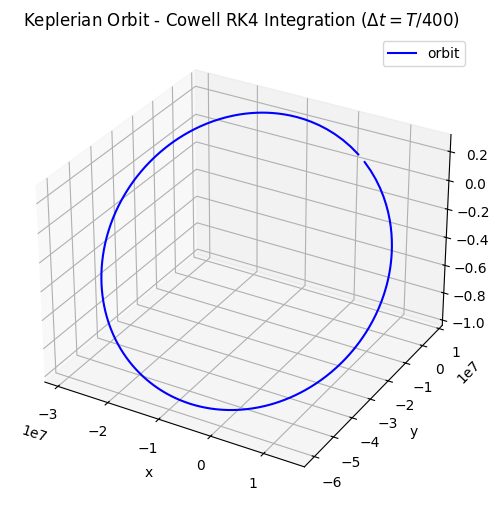

In [21]:
f = lambda t, X: X_ddot(t, X)

x0 = np.concatenate((x_vec, v_vec))
t0 = 0
tf = T
dt = T/400

x_pc2, t2 = RK4(f, x0, tf, dt, t0)

fig = plt.figure(figsize=(12, 6))

ax = plt.axes(projection="3d")
ax.plot3D(x_pc2[0][:], x_pc2[1][:], x_pc2[2][:], 'blue', label="orbit")
ax.legend()

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title("Keplerian Orbit - Cowell RK4 Integration ($\Delta t=T/400$)")


plt.show()

In [43]:
# Define a simple model
model = nn.Linear(in_features=6, out_features=6)  # Change architecture as necessary

# Example input and target
state = torch.tensor(x0, dtype=torch.float32, requires_grad=True)
#state = torch.randn(1, 6, requires_grad=True)  # State must require_grad to compute gradients w.r.t. it
target = torch.randn(1, 6)

# Loss function
criterion = nn.MSELoss()

# Forward pass
prediction = model(state)

# Compute loss
loss = criterion(prediction, target)

# Backward pass
loss.backward()

# Gradient of the loss with respect to the state
state_grad = state.grad

C:\Users\rod-n\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 6])) that is different to the input size (torch.Size([6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [44]:
# Collect all parameters into a single vector
theta_vector = torch.cat([p.view(-1) for p in model.parameters() if p.requires_grad])

# Print the vector
print(theta_vector)

tensor([-0.0685, -0.2085,  0.2877,  0.0704, -0.1089, -0.3569,  0.2522, -0.3084,
        -0.2669, -0.0371, -0.3438,  0.2818, -0.3227,  0.1208,  0.3620, -0.2662,
         0.2659,  0.1359, -0.2434, -0.0779, -0.2428, -0.0855,  0.2628, -0.0287,
         0.1260,  0.2869, -0.1649, -0.3642,  0.2891,  0.2847, -0.0819,  0.3890,
         0.3269,  0.3964,  0.1152, -0.1354, -0.2457, -0.0214,  0.0777,  0.2351,
        -0.0825, -0.0533], grad_fn=<CatBackward0>)


In [56]:
state

tensor([ 1.8890e+06,  6.6522e+06,  9.0248e+05, -9.5858e+03,  2.4136e+03,
         2.2735e+03], requires_grad=True)

In [57]:
np.linalg.norm(state.detach().numpy())

6973859.0

In [61]:
z = state
t = np.arange(t0, tf, dt)
t = torch.tensor(t, dtype=torch.float32, requires_grad=True)
a = state_grad # Gradient of the loss with respect to the state
theta = theta_vector
module = X_ddot

aug_dynamics(z, t, theta, a, module)

RuntimeError: Mismatch in shape: grad_output[0] has a shape of torch.Size([6]) and output[0] has a shape of torch.Size([400]).